In [54]:
import numpy as np
import os
import sys
from dataclasses import dataclass
from typing import List, Dict
import math
import matplotlib.pyplot as plt

In [61]:


@dataclass
class ClassificationResult:
    filename: str
    score: float
    predicted: bool
    actual: bool
    correct: bool

class Metrics:
    def __init__(self):
        self.true_positives = 0
        self.true_negatives = 0
        self.false_positives = 0
        self.false_negatives = 0

    def accuracy(self) -> float:
        total = self.true_positives + self.true_negatives + self.false_positives + self.false_negatives
        return (self.true_positives + self.true_negatives) / total if total > 0 else 0.0

    def sensitivity(self) -> float:
        actual_positives = self.true_positives + self.false_negatives
        return self.true_positives / actual_positives if actual_positives > 0 else 0.0

    def specificity(self) -> float:
        actual_negatives = self.true_negatives + self.false_positives
        return self.true_negatives / actual_negatives if actual_negatives > 0 else 0.0

    def precision(self) -> float:
        predicted_positives = self.true_positives + self.false_positives
        return self.true_positives / predicted_positives if predicted_positives > 0 else 0.0

class CardiomegalyClassifier:
    def __init__(self, weights_file: str, labels_file: str, classification_threshold: float = 0.5):
        self.threshold = classification_threshold
        self.weights = None
        self.labels = []
        self.labels_file_path = labels_file

        self.load_weights(weights_file)
        self.load_labels(labels_file)

    def load_weights(self, filename: str):
        print(f"Caricamento pesi da: {filename}")
        try:
            arr = np.load(filename)
        except Exception as e:
            print(f"Errore durante il caricamento dei pesi {filename} : {e}")
            sys.exit(1)

        if arr.shape != (224, 224):
            print(f"Errore: i pesi devono essere 224x224. Shape attuale: {arr.shape}")
            sys.exit(1)

        # Assicura che i pesi siano float32
        self.weights = arr.astype(np.float32).flatten()
        print(f"Pesi caricati: {self.weights.size} elementi")

    def load_labels(self, filename: str):
        print(f"Caricamento labels da: {filename}")
        try:
            arr = np.load(filename)
        except Exception as e:
            print(f"Errore durante il caricamento delle labels {filename}: {e}")
            sys.exit(1)

        if arr.ndim != 2 or arr.shape[1] != 14:
            print(f"Errore: formato labels errato. attualmente {arr.shape}")
            sys.exit(1)
        
        num_samples = arr.shape[0]
        label_index_cardiomegaly = 1 # Cardiomegalia è all'indice 1 (0-based)
        self.labels = (arr[:, label_index_cardiomegaly] > 0).astype(int).tolist()
        
        print(f"Labels caricate: {len(self.labels)} elementi (solo cardiomegalia)")

    def _calculate_score(self, image_file: str) -> float: # Cambiato in _calculate_score
        try:
            arr = np.load(image_file)
        except Exception as e:
            raise RuntimeError(f"Errore durante caricamento immagine {image_file}: {e}") # Aggiunto 'e' nel messaggio di errore

        if arr.ndim == 2:
            image_data = arr.flatten()
            # num_channels = 1 # Non necessario se la logica è separata
        elif arr.ndim == 3 and arr.shape[2] == 1:
            image_data = arr.flatten()
            # num_channels = 1 # Non necessario se la logica è separata
        elif arr.ndim == 3 and arr.shape[2] in [3, 4]:
            image_data = arr.reshape(-1, arr.shape[2])
            num_channels = arr.shape[2]
            pixels_per_channel = arr.shape[0] * arr.shape[1]
            if pixels_per_channel != self.weights.size:
                raise RuntimeError(f"Dimensioni immagine ({pixels_per_channel}) non corrispondono ai pesi ({self.weights.size})")

            total_score = 0.0
            for c in range(num_channels):
                channel_data = image_data[:, c]

                if arr.dtype == np.uint8:
                    normalized_0_1 = channel_data.astype(np.float32) / 255.0
                    normalized_neg1_1 = (normalized_0_1 - 0.5) / 0.5
                elif arr.dtype == np.float32:
                    normalized_neg1_1 = (channel_data - 0.5) / 0.5
                else:
                    raise RuntimeError(f"Tipo di dato dell'immagine ({arr.dtype}) non supportato per immagini a più canali.") # Messaggio più specifico

                total_score += np.sum(normalized_neg1_1 * self.weights)
            return total_score / num_channels
        else:
            raise RuntimeError(f"Formato immagine .npy non compatibile. Shape attuale: {arr.shape}")

        # Questa parte del codice verrà eseguita solo se l'immagine è 2D o (H,W,1)
        if arr.dtype == np.uint8:
            normalized_0_1 = image_data.astype(np.float32) / 255.0
            normalized_neg1_1 = (normalized_0_1 - 0.5) / 0.5
        elif arr.dtype == np.float32:
            normalized_neg1_1 = (image_data - 0.5) / 0.5
        else:
            raise RuntimeError(f"Tipo di dato dell'immagine ({arr.dtype}) non supportato. Previsto uint8 o float32.")
        
        score = np.sum(normalized_neg1_1 * self.weights)
        return score

    def classify_all(self, images_dir: str) -> List[ClassificationResult]:
        results: List[ClassificationResult] = []
        image_files: List[str] = []
        labels_filename_only = os.path.basename(self.labels_file_path)

        for entry in os.listdir(images_dir):
            full_path= os.path.join(images_dir, entry)
            if os.path.isfile(full_path) and entry.endswith('.npy'):
                if entry == labels_filename_only:
                    continue
                image_files.append(entry)

        image_files.sort()

        print(f"Classificazione di {len(image_files)} immagini...")

        if not image_files:
            print(f"Nessuna immagine .npy trovata nella directory: {images_dir} (o solo il file labels.npy).")
            return results

        if len(self.labels) != len(image_files):
            print(f"Attenzione: Il numero di etichette nel file NPY ({len(self.labels)}) non corrisponde al numero di immagini trovate ({len(image_files)}). La classificazione potrebbe essere inaccurata.")

        for i, filename in enumerate(image_files):
            if i >= len(self.labels):
                print(f"Avviso: Immagine {filename} non ha una label corrispondente. Saltata.")
                continue

            image_path = os.path.join(images_dir, filename)
            try:
                score = self._calculate_score(image_path) # Chiamata a _calculate_score
                predicted = score > self.threshold
                actual = bool(self.labels[i]) # 0=sano, >0=cardiomegalia
                correct = (predicted == actual)

                results.append(ClassificationResult(filename, score, predicted, actual, correct))

            except Exception as e:
                print(f"Errore nell'elaborazione di {filename}: {e}")

        return results

    def calculate_metrics(self, results: List[ClassificationResult]) -> Metrics:
        metrics = Metrics()
        for res in results:
            if res.actual:
                if res.predicted:
                    metrics.true_positives += 1
                else:
                    metrics.false_negatives += 1
            else:
                if res.predicted:
                    metrics.false_positives += 1
                else:
                    metrics.true_negatives += 1
        return metrics

    def set_threshold(self, new_threshold: float):
        self.threshold = new_threshold

    def get_threshold(self) -> float:
        return self.threshold

    def print_label_distribution(self):
        if not self.labels:
            print("le etichette non sono ancora state caricate")
            return

        total_positives = sum(self.labels)
        total_negatives = len(self.labels) - total_positives

        print("\n=== DISTRIBUZIONE DELLE CLASSI NEL DATASET ===")
        print(f"Totale campioni: {len(self.labels)}")
        print(f"Campioni Positivi (Cardiomegalia): {total_positives}")
        print(f"Campioni Negativi (Normali): {total_negatives}")
        print("===========================================")


# --- FUNZIONE display_classification_examples (FUORI DALLA CLASSE) ---
def display_classification_examples(title: str, examples: List[ClassificationResult], images_dir: str, limit: int = 5):
    if not examples:
        print(f"\nNessun esempio per: {title}")
        return

    print(f"\n--- {title} (Primi {min(len(examples), limit)} esempi) ---")
    
    # Calcola il numero di righe e colonne per il subplot
    num_display = min(len(examples), limit)
    if num_display == 0:
        print("Nessun esempio da mostrare.")
        return

    # Determinare la griglia per i subplot
    cols = 5 # Numero massimo di colonne
    rows = (num_display + cols - 1) // cols # Calcola il numero di righe necessarie

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten() # Appiattisci l'array di assi per iterare facilmente

    for i, res in enumerate(examples[:limit]):
        if i >= len(axes): # Evita errori se ci sono più esempi del previsto nel subplot grid
            break
            
        img_path = os.path.join(images_dir, res.filename)
        try:
            img_data = np.load(img_path)
            # Gestisci immagini a 3 canali (es. RGB)
            if img_data.ndim == 3 and img_data.shape[2] in [3, 4]:
                # Se l'immagine è RGB/RGBA, plt.imshow la gestisce direttamente
                if img_data.shape[2] == 4: # Se RGBA, rimuovi il canale alfa se non necessario per la visualizzazione
                    img_data = img_data[:, :, :3]
                axes[i].imshow(img_data)
            else: # Immagini in scala di grigi (2D o 3D con canale singolo)
                # Assicurati che l'immagine sia 2D per imshow in scala di grigi
                if img_data.ndim == 3 and img_data.shape[2] == 1:
                    img_data = img_data.squeeze() # Rimuovi la dimensione del canale singolo
                axes[i].imshow(img_data, cmap='gray')
            
            actual_str = "POS" if res.actual else "NEG"
            predicted_str = "POS" if res.predicted else "NEG"
            correct_char = "✓" if res.correct else "✗"
            
            axes[i].set_title(f"File: {res.filename}\nScore: {res.score:.2f}\nActual: {actual_str} Pred: {predicted_str} {correct_char}", fontsize=8)
            axes[i].axis('off') # Rimuovi gli assi per una visualizzazione più pulita
        except Exception as e:
            axes[i].set_title(f"Errore caricamento {res.filename}\n{e}", fontsize=8, color='red')
            axes[i].axis('off')

    # Nascondi gli assi rimanenti se num_display < len(axes)
    for j in range(num_display, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout() # Adatta i subplot per evitare sovrapposizioni
    plt.show() # Mostra la figura

# --- Funzione print_results aggiornata (se l'hai usata prima, assicurati di aggiornarla) ---
# Se stai usando questa funzione, ora deve chiamare la display_classification_examples
# che è una funzione standalone, non un metodo della classe.
def print_results(results: List[ClassificationResult], metrics: Metrics, images_dir: str):
    print("\n=== RISULTATI CLASSIFICAZIONE ===")
    print("\nMETRICHE:")
    print(f"Accuracy:    {metrics.accuracy() * 100:.3f}%")
    print(f"Sensitivity: {metrics.sensitivity() * 100:.3f}%")
    print(f"Specificity: {metrics.specificity() * 100:.3f}%")
    print(f"Precision:   {metrics.precision() * 100:.3f}%")

    print("\nCONFUSION MATRIX:")
    print("                 Predicted")
    print("                 Negative Positive")
    print(f"Actual   Negative {metrics.true_negatives:8d} {metrics.false_positives:8d}")
    print(f"         Positive {metrics.false_negatives:8d} {metrics.true_positives:8d}")

    print("\nPRIMI 10 RISULTATI:")
    print("File                Score    Pred  Actual  Correct")
    print("------------------------------------------------")
    
    for r in results[:10]:
        filename_short = r.filename[:15].ljust(15)
        score_str = f"{r.score:7.3f}"
        predicted_str = "POS" if r.predicted else "NEG"
        actual_str = "POS" if r.actual else "NEG"
        correct_char = "✓" if r.correct else "✗"
        print(f"{filename_short}  {score_str}  {predicted_str:4s}  {actual_str:6s}  {correct_char}")

    print("\n=== ESEMPI DI CLASSIFICAZIONE SPECIFICI (Visualizzazione Immagini) ===")
    
    true_positives_examples = [r for r in results if r.actual and r.predicted]
    true_negatives_examples = [r for r in results if not r.actual and not r.predicted]
    false_positives_examples = [r for r in results if not r.actual and r.predicted]
    false_negatives_examples = [r for r in results if r.actual and not r.predicted]

    display_classification_examples("VERI POSITIVI", true_positives_examples, images_dir)
    display_classification_examples("VERI NEGATIVI", true_negatives_examples, images_dir)
    display_classification_examples("FALSI POSITIVI", false_positives_examples, images_dir)
    display_classification_examples("FALSI NEGATIVI", false_negatives_examples, images_dir)

Caricamento pesi da: ../data/weights/cardiomegaly_weights_224x224_trained.npy
Pesi caricati: 50176 elementi
Caricamento labels da: ../data/ChestMNIST_Images/labels.npy
Labels caricate: 22433 elementi (solo cardiomegalia)

=== DISTRIBUZIONE DELLE CLASSI NEL DATASET ===
Totale campioni: 22433
Campioni Positivi (Cardiomegalia): 582
Campioni Negativi (Normali): 21851
Classificazione di 22433 immagini...

=== RISULTATI CLASSIFICAZIONE ===

METRICHE:
Accuracy:    84.144%
Sensitivity: 14.605%
Specificity: 85.996%
Precision:   2.703%

CONFUSION MATRIX:
                 Predicted
                 Negative Positive
Actual   Negative    18791     3060
         Positive      497       85

PRIMI 10 RISULTATI:
File                Score    Pred  Actual  Correct
------------------------------------------------
image_0000.npy   -58.439  NEG   NEG     ✓
image_0001.npy   -112.351  NEG   NEG     ✓
image_0002.npy   -40.538  NEG   NEG     ✓
image_0003.npy   -71.985  NEG   NEG     ✓
image_0004.npy   -77.842 

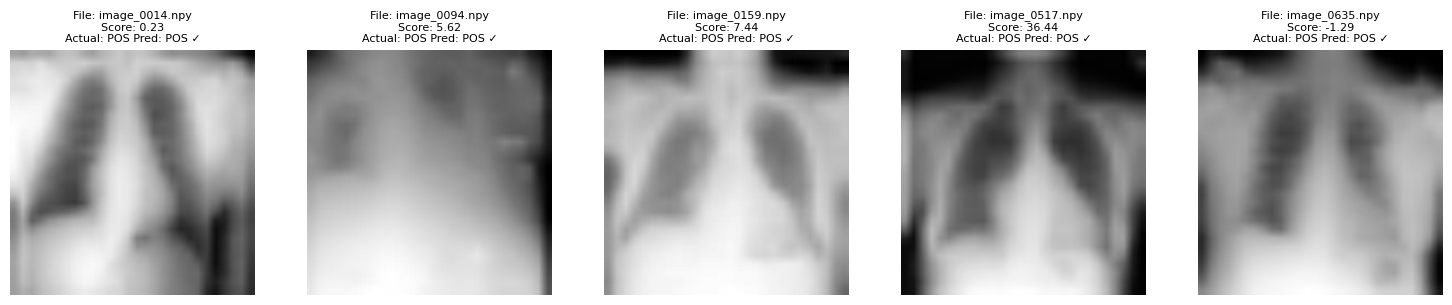


--- VERI NEGATIVI (Primi 5 esempi) ---


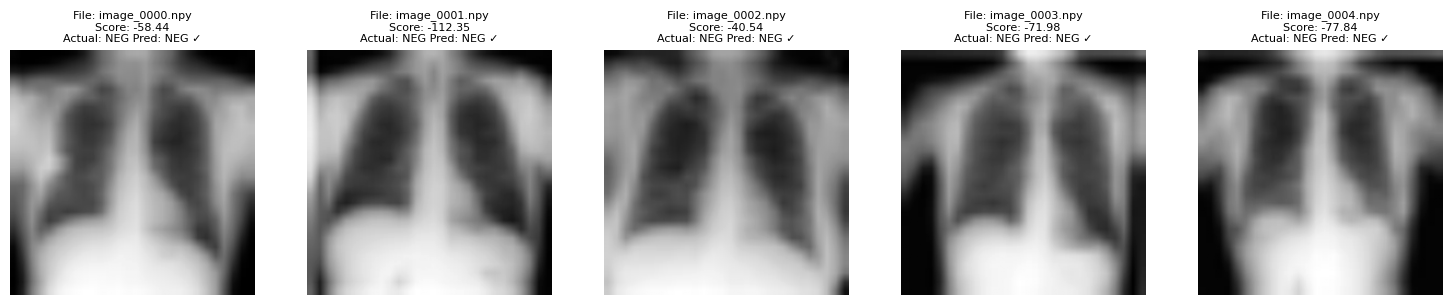


--- FALSI POSITIVI (Primi 5 esempi) ---


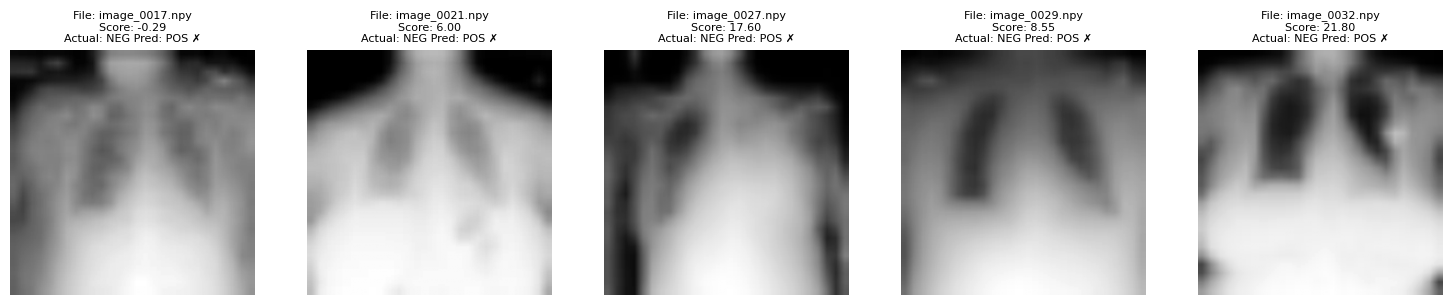


--- FALSI NEGATIVI (Primi 5 esempi) ---


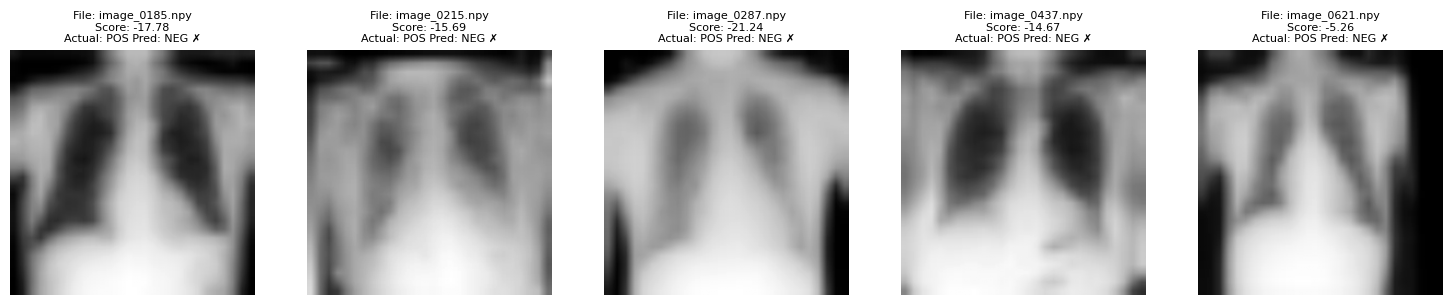


=== TEST THRESHOLD DIVERSI ===
Threshold -1.5: Acc=84.523%, Sens=14.261%, Spec=86.394%
Threshold -1.0: Acc=84.937%, Sens=13.574%, Spec=86.838%
Threshold -0.5: Acc=85.405%, Sens=13.230%, Spec=87.328%
Threshold  0.0: Acc=85.789%, Sens=12.543%, Spec=87.740%
Threshold  0.5: Acc=86.226%, Sens=11.684%, Spec=88.211%


In [66]:
weights_file = "../data/weights/cardiomegaly_weights_224x224_trained.npy"
labels_file = "../data/ChestMNIST_Images/labels.npy"
images_dir = "../data/ChestMNIST_Images"
threshold = -2

try:
        classifier = CardiomegalyClassifier(weights_file, labels_file, threshold)
        classifier.print_label_distribution()
        results = classifier.classify_all(images_dir)
        metrics = classifier.calculate_metrics(results)
        print_results(results, metrics, images_dir)

        print("\n=== TEST THRESHOLD DIVERSI ===")
        thresholds_to_test = [-1.5,-1.0, -0.5, 0.0, 0.5,]
        
        # Ri-valuta i risultati con diverse soglie
        # Memorizza i risultati base una volta
        re_evaluated_results_for_all_thresholds = [] 
        for res in results:
            # Inizia con i risultati predetti/corretti originali, poi aggiorna per ogni soglia
            re_evaluated_results_for_all_thresholds.append(ClassificationResult(res.filename, res.score, res.predicted, res.actual, res.correct))

        for th in thresholds_to_test:
            # Crea una nuova lista per i risultati della soglia corrente
            current_th_results = []
            for res_base in re_evaluated_results_for_all_thresholds:
                predicted_th = res_base.score > th
                correct_th = (predicted_th == res_base.actual)
                current_th_results.append(ClassificationResult(res_base.filename, res_base.score, predicted_th, res_base.actual, correct_th))
            
            th_metrics = classifier.calculate_metrics(current_th_results)
            print(f"Threshold {th: .1f}: Acc={th_metrics.accuracy() * 100:.3f}%, Sens={th_metrics.sensitivity() * 100:.3f}%, Spec={th_metrics.specificity() * 100:.3f}%")

except Exception as e:
    print(f"Errore {e}")